# Analýza a predikce mozkové příhody u obecné populace

## Obecný popis situace

Cévní mozková příhoda (CMP) je náhle se rozvíjející postižení určité části mozkové tkáně vzniklé poruchou jejího prokrvení. K této poruše může dojít buď na základě blokace mozkové tepny, nebo na základě krvácení z mozkové cévy. CMP je akutní stav, který vyžaduje neodkladnou lékařskou pomoc. Je zásadní příhodu včas rozpoznat a okamžitě pacienta přepravit do zdravotnického zařízení, aby se předešlo ztrátě pohyblivosti a řeči. Během jedné minuty odumírají miliony buněk. Doprava, diagnostika a léčba proto na sebe musí navazovat v minutách. Pokud se jedná o krevní sraženinu a její rozpouštění začne do 60 minut po vzniku příznaků, pacient má 70% naději na úplné uzdravení.

## Obecná formulace úlohy

Pro tento modelový příklad si můžeme představit, že pracujeme pro zdravotní pojišťovnu, která chce u svých klientů snížit pravděpodobnost CMP. Pojišťovně se tak sníží náklady na ošetřovné. Naším úkolem je tedy vytvořit model, který bude schopný na základě základních zdravotnických dat předpovědět, zda je daný pacient v ohrožení.


## Analýza situace

CMP byla v roce 2011 druhou nejčastější příčinou úmrtí na celém světě, což představuje 6,2 milionu úmrtí (~ 11 % celkového počtu). V roce 2010 utrpělo CMP přibližně 17 milionů lidí. V letech 1990 až 2010 se počet mrtvic v rozvinutém světě snížil přibližně o 10 % a v rozvojovém světě se zvýšil o 10 %. Celkově se dvě třetiny těchto příhod vyskytly u osob starších 65 let.

Riziko CMP se exponenciálně zvyšuje od 30 let. Pokročilý věk je jedním z nejvýznamnějších rizikových faktorů CMP. 95 % cévních mozkových příhod se vyskytuje u lidí ve věku 45 let a starších a dvě třetiny CMP se vyskytují u osob starších 65 let. Riziko úmrtí člověka, pokud má CMP, se také zvyšuje s věkem. CMPa se však může objevit v jakémkoli věku, včetně dětství.

U mužů je o 25 % vyšší pravděpodobnost mrtvice než u žen, přesto se 60 % úmrtí na CMP vyskytuje u žen. Vzhledem k tomu, že ženy žijí déle, jsou v průměru starší, když se jim mrtvice přihodí, a nemoc je tak častěji smrtelná.

## Formulace úlohy

Naším cílem je analyzovat výchozí dataset, vyčistit jej od chybných dat, analyzovat trendy a korelace mezi styčnými sloupci a konečně vytvořit model, který bude za svůj vstup považovat náhodný vzorek z tohoto datasetu a vytvoří predikci, zda danému člověku hrozí CMP.

Importování využitých knihoven

In [3]:
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.tree import *
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr
from scipy import stats

## Náš dataset

Podle Světové zdravotnické organizace (WHO) je mozková příhoda druhou nejčastější příčinou úmrtí na celém světě a je odpovědná za přibližně 11 % celkového počtu úmrtí.
Tato datová sada se používá k předpovědi pravděpodobnosti cévní mozkové příhody u pacienta, na základě vstupních parametrů, jako je pohlaví, věk, různá onemocnění a fakt, zda je dotyčný kuřákem či nekuřákem. Každý řádek v datech poskytuje důležité informace o pacientovi.

1) id: unikátní identifikátor

2) pohlaví: „Muž“, „Žena“ nebo „Jiné“

3) věk: věk pacienta

4) hypertenze: 0, pokud pacient nemá hypertenzi, 1, pokud pacient má hypertenzi

5) onemocnění srdce: 0, pokud pacient nemá žádné srdeční choroby, 1 pokud pacient má srdeční onemocnění

6) vdaná/ženatý: „Ne“ nebo „Ano“

7) Typ zaměstnání: "Dítě", "Záměstnán pro vládu", "Nepracoval", "Zaměstnán u soukromníka" nebo "Živnostník"

8) Typ rezidence: „Venkov“ nebo „Město“

9) avg_glucose_level: průměrná hladina glukózy v krvi 

10) bmi: index tělesné hmotnosti

11) smoking_status: "Dříve kouřil", "Nikdy nekouřil", "Kouří" nebo "Unknown" *

12) Cévní mozková příhoda: 1, pokud měl pacient mrtvici, nebo 0, pokud ji neměl

*Poznámka: „unknown“ v řádku smoking_status znamená, že informace o tomto pacientovi není k dispozici

*Poznámka: Dataset je ponechán v angličtině

In [4]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [5]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
df.shape

(5110, 12)

### Odstranění zbytečných sloupců

In [7]:
data = df.drop('id', axis=1)
data = data[data.gender != 'Other']
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Hledání unikátních hodnot v kategoriích

In [8]:
Unique_in_category = ['gender', 'hypertension', 'heart_disease','ever_married', 'work_type', 'Residence_type', 'smoking_status']
for Unique in Unique_in_category:
    print(data[Unique].unique())

['Male' 'Female']
[0 1]
[1 0]
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


### Kontrola chybějících hodnot

In [9]:
data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### Vykreslení grafů pro kategorická data

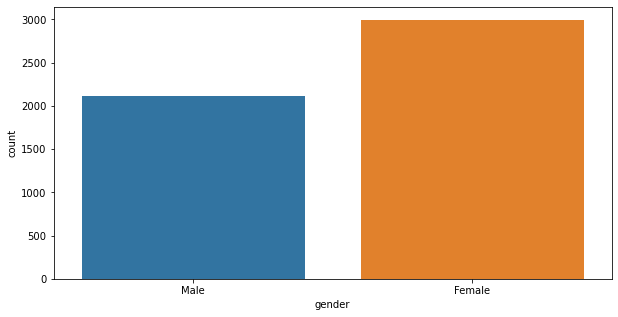

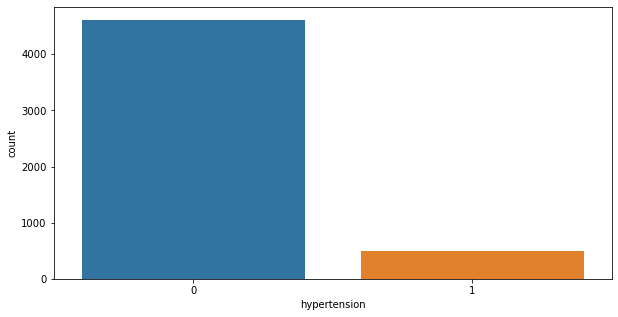

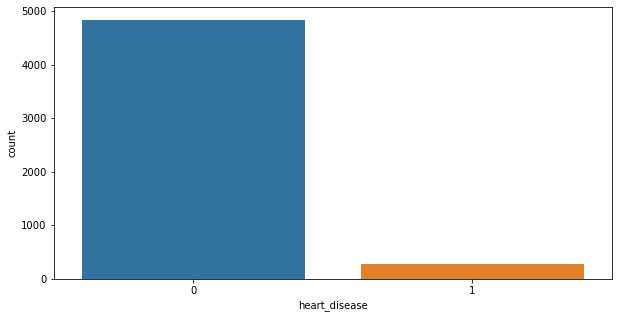

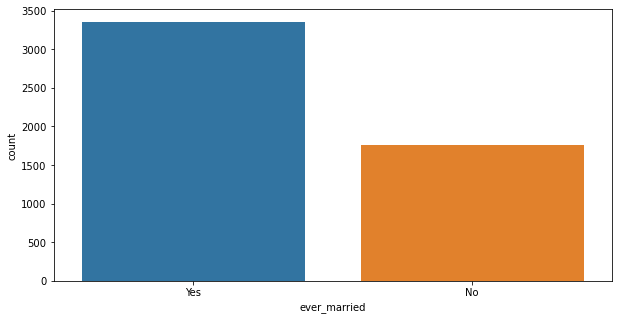

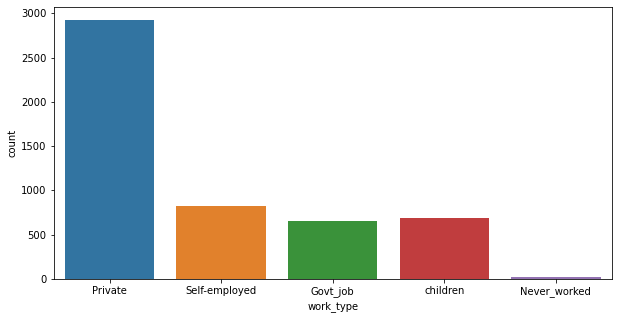

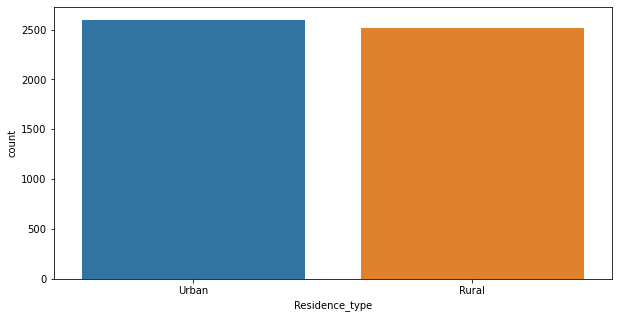

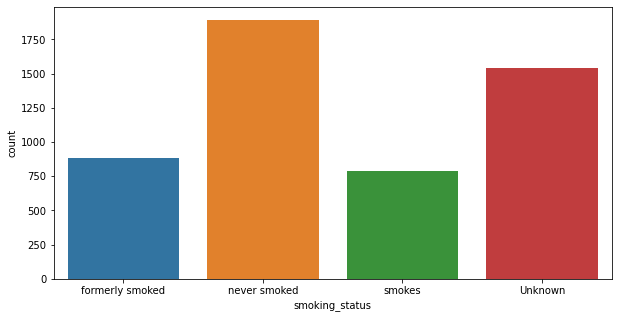

In [22]:
for Unique in Unique_in_category:
    plt.figure(figsize=(10,5))
    sns.countplot(x = data[Unique])
    plt.show()

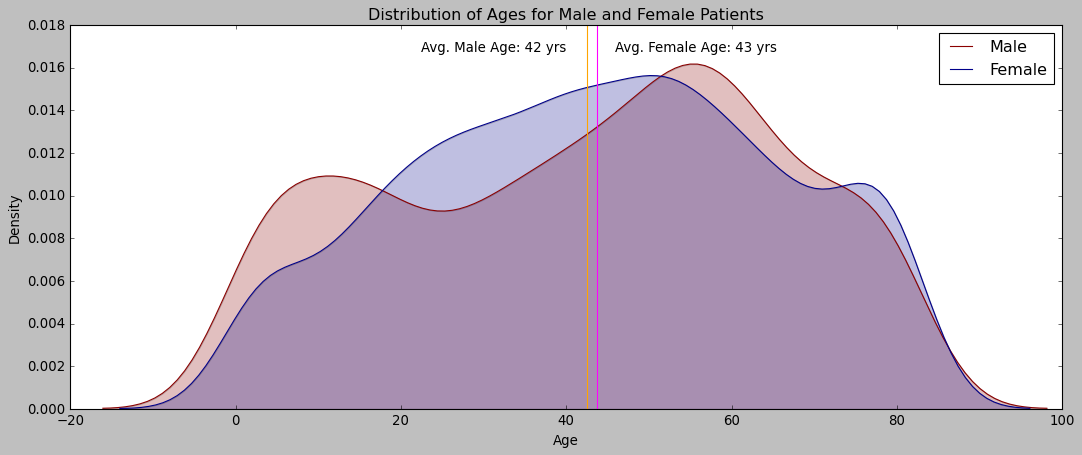

In [12]:
avg_male_age = data[data['gender'] == 'Male']['age'].mean()
avg_female_age = data[data['gender'] == 'Female']['age'].mean()

plt.style.use("classic")
plt.figure(figsize=(16, 6))
sns.kdeplot(data.loc[data['gender'] == 'Male', 'age'], label = 'Male', shade=True, color='darkred')
sns.kdeplot(data.loc[data['gender'] == 'Female', 'age'], label = 'Female', shade=True, color='darkblue')

plt.axvline(avg_male_age, color='orange', linestyle='-', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(avg_male_age-20, max_ylim*0.93, 'Avg. Male Age: {} yrs'.format(int(avg_male_age)))

plt.axvline(avg_female_age, color='magenta', linestyle='-', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(avg_female_age*1.05, max_ylim*0.93, 'Avg. Female Age: {} yrs'.format(int(avg_female_age)))

plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution of Ages for Male and Female Patients')
plt.legend()
plt.show()

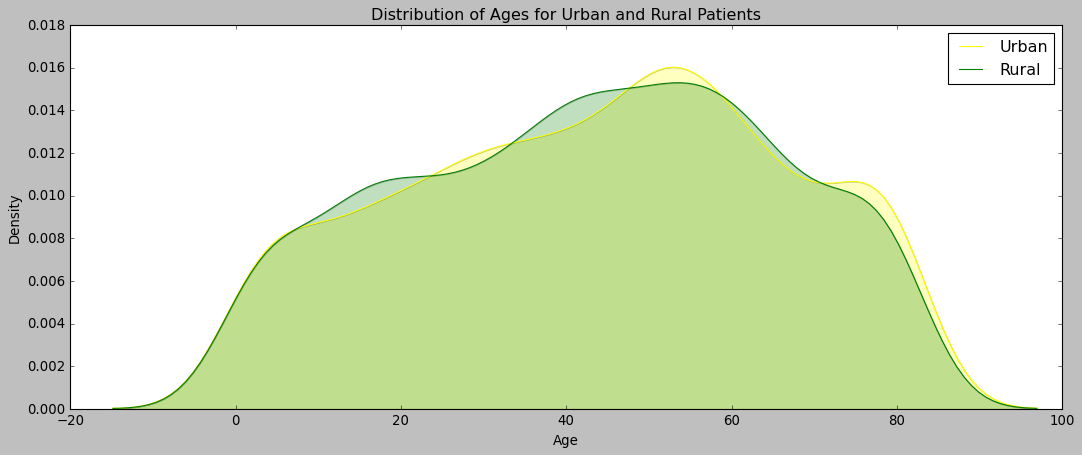

In [24]:
plt.style.use("classic")
plt.figure(figsize=(16, 6))
sns.kdeplot(data.loc[data['Residence_type'] == 'Urban', 'age'], label = 'Urban', shade=True, color='yellow')
sns.kdeplot(data.loc[data['Residence_type'] == 'Rural', 'age'], label = 'Rural', shade=True, color='green')

plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution of Ages for Urban and Rural Patients')
plt.legend()
plt.show()

### Chybějící hodnoty

Hodnotu „unknown“ v řádku smoking_status budeme považovat za chybějící.

In [25]:
data['smoking_status'].replace('Unknown', np.nan, inplace=True)

In [26]:
data.isna().sum()

gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64

### Vyplnění chybějících hodnot

Chybějící hodnoty ve sloupci „bmi“ nahradíme střední hodnotou.

Chybějící hodnoty ve sloupci „smoking_status“ nahradíme modusem.

In [27]:
data['bmi'].fillna(data['bmi'].mean(), inplace=True)
data['smoking_status'].fillna(data['smoking_status'].mode()[0], inplace = True)

data.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Přehled numerických statistik našeho již upraveného datasetu

In [28]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,43.229986,0.097475,0.054022,106.140399,28.894560,0.048738
std,22.613575,0.296633,0.226084,45.285004,7.698235,0.215340
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.240000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.880000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### Vykreslení grafů pro kategorie s nahrazenými hodnotami

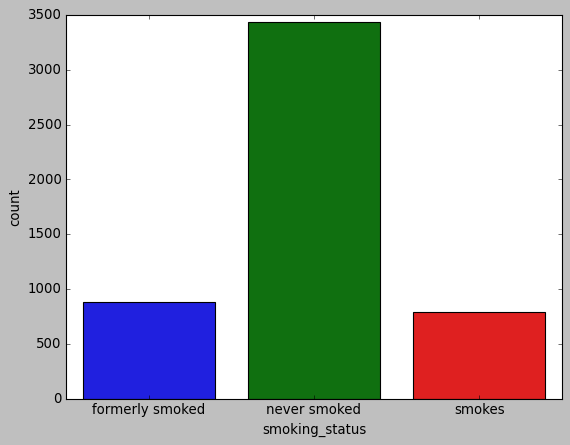

In [29]:
sns.countplot(x = data['smoking_status'])

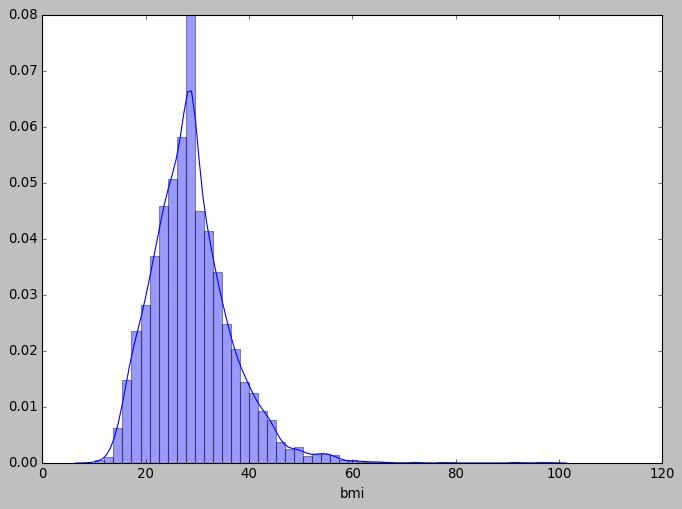

In [30]:
plt.figure(figsize=(10,7))
sns.distplot(data["bmi"])
plt.show()

### Korelace mezi proměnnými

In [31]:
data.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.276367,0.263777,0.238323,0.325861,0.245239
hypertension,0.276367,1.000000,0.108292,0.174540,0.160151,0.127891
heart_disease,0.263777,0.108292,1.000000,0.161907,0.038865,0.134905
avg_glucose_level,0.238323,0.174540,0.161907,1.000000,0.168913,0.131991
bmi,0.325861,0.160151,0.038865,0.168913,1.000000,0.038917
stroke,0.245239,0.127891,0.134905,0.131991,0.038917,1.000000


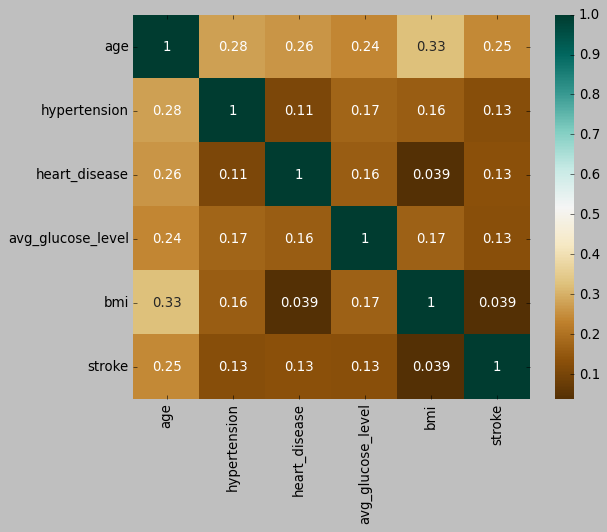

In [32]:
sns.heatmap(data.corr(), annot=True, cmap='BrBG')

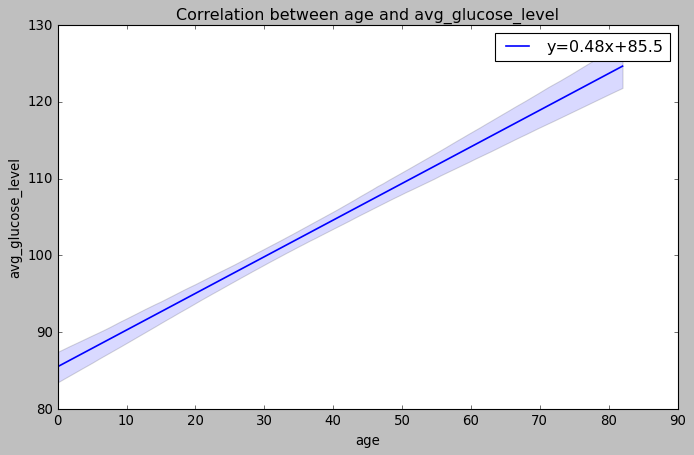

In [33]:
plt.figure(figsize=(10,6))
slope, intercept, r_value, p_value, std_err = stats.linregress(data['age'],data['avg_glucose_level'])
plt.title("Correlation between age and avg_glucose_level")
sns.regplot(x="age", y="avg_glucose_level", data=data, scatter=False,
           label="y={0:.2f}x+{1:.1f}".format(slope, intercept)).legend(loc="best");

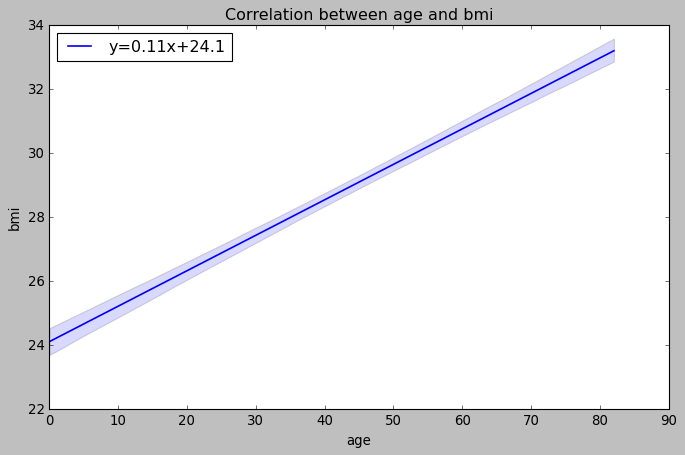

In [34]:
plt.figure(figsize=(10,6))
slope, intercept, r_value, p_value, std_err = stats.linregress(data['age'],data['bmi'])
plt.title("Correlation between age and bmi")
sns.regplot(x="age", y="bmi", data=data, scatter=False,
           label="y={0:.2f}x+{1:.1f}".format(slope, intercept)).legend(loc="best");

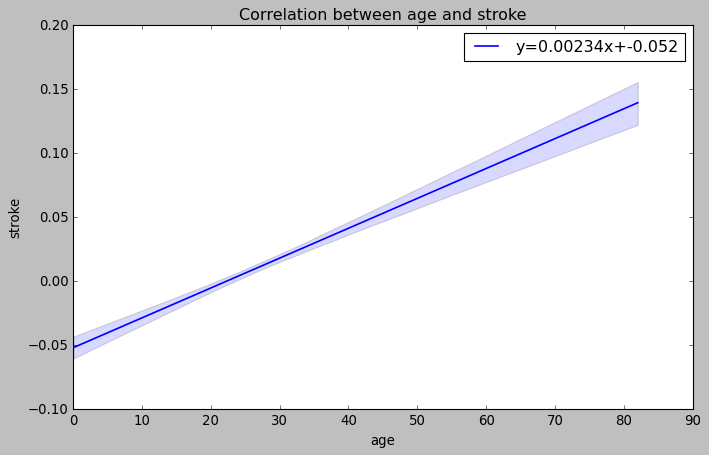

In [35]:
plt.figure(figsize=(10,6))
slope, intercept, r_value, p_value, std_err = stats.linregress(data['age'],data['stroke'])
plt.title("Correlation between age and stroke")
sns.regplot(x="age", y="stroke", data=data, scatter=False,
           label="y={0:.5f}x+{1:.3f}".format(slope, intercept)).legend(loc="best");

## Decision tree prediction model (tzv. model predikce pomocí rozhodovacího stromu)

Nejprve překódujeme kategorické sloupce do sloupců obsahujících pouze `0` a `1`. Poté odstraníme zbytečné kategorické sloupce, aby nám zbyly pouze sloupce s numerickými hodnotami.

In [36]:
cat = ['gender','ever_married','Residence_type','smoking_status','work_type']
for i in cat:
    dummy = pd.get_dummies(data[i],drop_first=True,prefix=f"{i}_")
    data = pd.concat([data,dummy],axis=1)

In [37]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender__Male,ever_married__Yes,Residence_type__Urban,smoking_status__never smoked,smoking_status__smokes,work_type__Never_worked,work_type__Private,work_type__Self-employed,work_type__children
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60000,formerly smoked,1,1,1,1,0,0,0,1,0,0
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.89456,never smoked,1,0,1,0,1,0,0,0,1,0
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50000,never smoked,1,1,1,0,1,0,0,1,0,0
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40000,smokes,1,0,1,1,0,1,0,1,0,0
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00000,never smoked,1,0,1,0,1,0,0,0,1,0


In [38]:
data = data.drop([*cat],axis=1)

In [39]:
data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender__Male,ever_married__Yes,Residence_type__Urban,smoking_status__never smoked,smoking_status__smokes,work_type__Never_worked,work_type__Private,work_type__Self-employed,work_type__children
0,67.0,0,1,228.69,36.60000,1,1,1,1,0,0,0,1,0,0
1,61.0,0,0,202.21,28.89456,1,0,1,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.50000,1,1,1,0,1,0,0,1,0,0
3,49.0,0,0,171.23,34.40000,1,0,1,1,0,1,0,1,0,0
4,79.0,1,0,174.12,24.00000,1,0,1,0,1,0,0,0,1,0


Shrnutí korelačních koeficientů pro každý sloupec s ohledem na sloupec "stroke".

In [40]:
data.corrwith(data['stroke'])

age                             0.245239
hypertension                    0.127891
heart_disease                   0.134905
avg_glucose_level               0.131991
bmi                             0.038917
stroke                          1.000000
gender__Male                    0.009081
ever_married__Yes               0.108299
Residence_type__Urban           0.015415
smoking_status__never smoked   -0.059007
smoking_status__smokes          0.008920
work_type__Never_worked        -0.014885
work_type__Private              0.011927
work_type__Self-employed        0.062150
work_type__children            -0.083888
dtype: float64

Rozdělení na dva datové rámce `X` a `y`. Tyto datové rámce poté dále rozdělíme na train a test. Pomocí datasetu train vytvoříme náš decision tree model a pomocí datového rámce test zhodnotíme jeho efektivitu.

F-skóre modelu se nám zobrazí jako výstup buňky.

In [41]:
X = data.drop('stroke',axis=1).values
y = data['stroke'].values

In [42]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    imputer = KNNImputer(n_neighbors=2)
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.fit_transform(X_test)
    
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f = f1_score(y_true = y_test , y_pred = y_pred,average = 'binary')
    
    print(f)

0.125
0.13559322033898305
0.18750000000000003
0.1276595744680851
0.11627906976744186


Jak vidíme, že naše f-skóre je velmi nízké. Můžeme si z toho odvodit, že zvolený model není pro binární predikce nejvhodnější. 

Jako výstup následující buňky můžeme vidět část grafického znázornění našeho modelu.

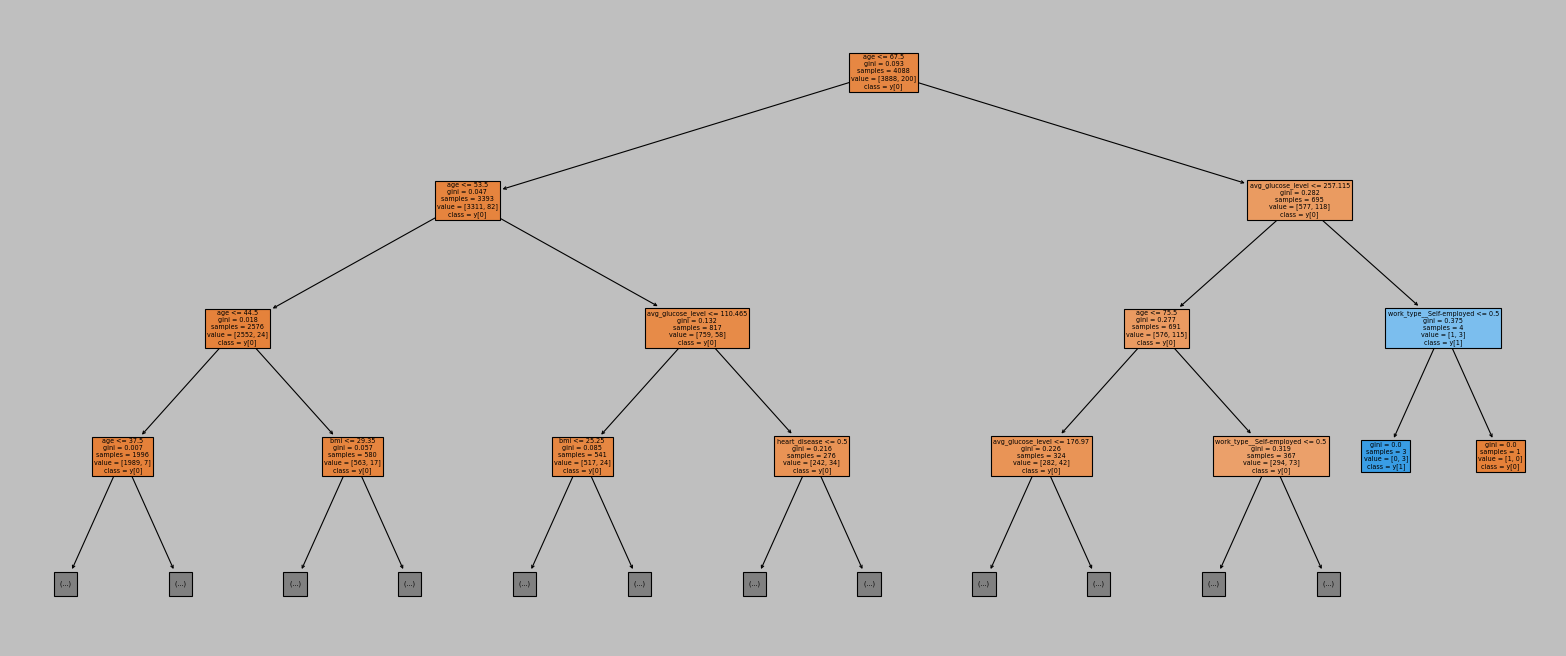

In [43]:
plt.figure(figsize=(25,10))
plot_tree(clf,feature_names=data.drop('stroke',axis=1).columns,max_depth = 3,filled=True,class_names = True)
plt.show()

### Použití modelu random forest classifier

Z předchozí ukázky můžeme vidět, že pouze jeden decision tree nám nestačí. Proto využijeme speciálního modelu, který nám umožňuje modely decision tree kombinovat. Jeho využitím dosáhneme vhodnějšího a efektivnějšího modelu.

Využijeme datové rámce `X` a `y` z předchozího modelu a znovu je rozdělíme na train a test set. Tentokrát využijeme funkci `train_test_split` z knihovny scikit-learn, abychom rámce na tyto dva sety rozdělili.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

Za pomocí knihovny scikit-learn standardizujeme naše data.

In [45]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Vytvoříme si model random forest classifier.

In [46]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

In [47]:
print("The Accuracy Score of RandomForestClassifier is: {:.3f}%".format(accuracy_score(y_test, y_pred)*100))

The Accuracy Score of RandomForestClassifier is: 95.018%


## Interpretace

Výsledkem naší analýzy je vytvořený model na základě vstupního datasetu o 5200 řádcích byl rozdělen v poměru 33/67 na tréninkový a testovací dataset. Vstupními parametry tohoto modelu jsou: ... . Tento model je schopný předvídat u pacientů cévní mozkové příhody ještě předtím, než nastanou, a to s pravděpodobností 95 %. 

## Implementace

Pokud chce zdravotní pojišťovna snížit riziko CMP musí u svých pacientů mít k dispozici nebo získat záznamy vstupních parametrů pro tento model. Nejprve však musí posoudit ekonomickou náročnost takovýchto opatření.Tedy zjistit náklady, které by pojišťovně vznikly v souvislosti se zíkáním a zpracováním takových informací a dále úspory, které by vznikly snížením množství pacientů s rozvinutou CMP. Fakticky tedy musí vytvořit CBA analýzu pro toto opatření. V případě jeho realizace předají informace získané z tohoto modelu svým smluvním lékařům a ti tak mohou těmto pacientům předepsat příslušné léky respektive zvolit vhodný preventivně léčebný postup, a tomuto nepříznivému vývoji tak předcházet. Současně by bylo vhodné umožnit těmto lékařům zadávat informace o vstupních parametrech vytvořeného modelu do databáze pojišťovny v reálném čase a pomáhat tak při diagnostice a prevenci tohoto onecmonění.